# Results Comparison of Various Models

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import numpy as np
import os
import operator
from mpl_toolkits.mplot3d import Axes3D
from zipfile import ZipFile

In [2]:
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = 8,5
plt.rcParams.update({'font.size': 9})
pd.set_option('display.float_format', '{:.3f}'.format)

In [3]:
def extract_results(filename):
    filename = '../outputs/' + filename
    with ZipFile(filename, 'r') as f:
        text = f.read(f.namelist()[0] + 'results.txt')
#         print(f.namelist())
    return text.decode('utf-8')

def load_results(filename):
    if filename.endswith('zip'):
        lines = extract_results(filename).split('\n')
    else:
        with open(filename) as f:
            lines = f.readlines()
            
    results = dict(run_id=[])
    for line in lines:
        run_id, rest = line.split()
        results['run_id'].append(run_id)
        for item in rest.split(','):
            key, value = item.split('=')
            if key in results:
                results[key].append(float(value))
            else:
                results[key] = [float(value)]
            
    return pd.DataFrame(results)

def plot_results(filename, dims=2):
    
    df = load_results('../outputs/' + filename)
    columns = list(df.columns)
    ylabel = [col for col in columns if col.endswith('_score')][0]
    xlabel = [col for col in columns if col.startswith('e')][0]
    zlabel = [col for col in columns if col not in (xlabel, ylabel, "runtime") and col != 'run_id'][0]
        
    results = df.groupby([xlabel, zlabel]).agg(['mean', 'min', 'max', 'std'])
    results.columns = ['mean', 'min', 'max', 'std']
    results = results.reset_index()
    if dims > 2:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        x, y = np.meshgrid(results[xlabel].unique(), results[zlabel].unique())
        z = results.set_index([xlabel, zlabel])[['mean']].unstack(zlabel)
        ax.plot_surface(x, z, y, cmap=cm.coolwarm, antialiased=True, linewidth=0, shade=True)
#         ax.view_init(5, 5)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(zlabel)
        ax.set_zlabel(ylabel)
    else:
        fig, ax = plt.subplots(1, 1, figsize=(9,6))
        for alpha, color in zip(results[zlabel].unique(), list('brgk')):
            sel = results[results[zlabel] == alpha].copy()
            ax.plot(sel[xlabel], sel['mean'], 'o--', label=alpha)
            ax.fill_between(sel[xlabel], sel['min'], sel['max'], alpha=0.2)

        plt.xscale('log')
        ax.legend()        
        ax.set_xlabel(xlabel)
        ax.set_ylabel('mean ' + ylabel)
    
    ax.set_title(filename.split('/')[0])

    display(df.groupby([xlabel, zlabel]).describe())

# Grid Search

In [87]:
run get_results.py --root=../outputs

<IPython.core.display.Javascript object>


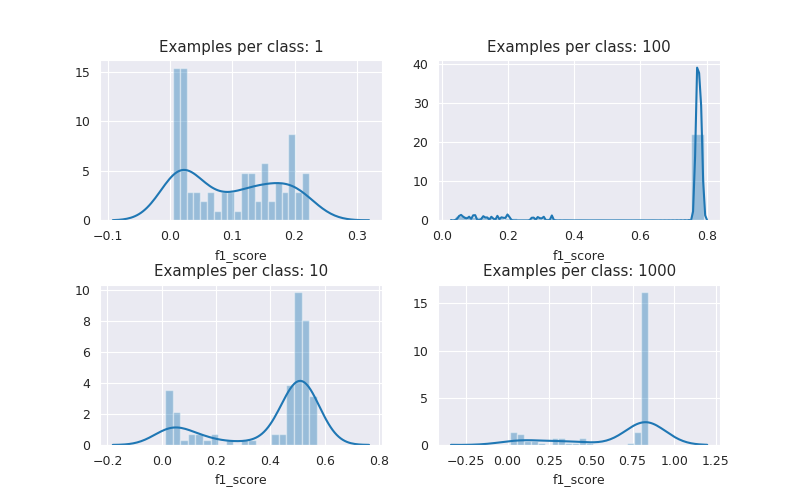

In [119]:
results = pd.read_csv('all_results.csv')

results = results.assign(
    competitive_topk=lambda df: df['competitive_topk'].fillna(0).astype('int'),
    examples_per_class=lambda df: df['examples_per_class'].astype('int'),
    contractive=lambda df: df['contractive'].fillna(0),
    penalty=lambda df: df['penalty'].fillna(''),
    penalty_weight=lambda df: df['penalty_weight'].fillna('')
)  #.where(results.model_name != 'kate').dropna()

fig, axs = plt.subplots(2, 2)

for i, epc in enumerate(sorted(results['examples_per_class'].unique())):
    sns.distplot(results.loc[results.examples_per_class == epc, 'f1_score'], bins=20, ax=axs[i%2,i//2])
    axs[i%2,i//2].set_title('Examples per class: {}'.format(epc))
        
    plt.subplots_adjust(hspace=0.4)

In [127]:
(results[results.model_name == 'kate']
 .sort_values('f1_score', ascending=False)
 .groupby(columns[:8])
 .agg(['mean', 'std'])
 .sort_values(('f1_score', 'mean'), ascending=False)
 .groupby(columns[:2])
 .head(1))

accuracy  \
                                                                                                         mean   
model_name examples_per_class alpha competitive_topk contractive encoder_dims penalty penalty_weight            
kate       1000               0.800 64               0.000       [128]                                  0.415   
           100                0.800 32               0.000       [128]                                  0.331   
           10                 0.200 16               0.000       [128]                                  0.148   
           1                  0.800 16               0.000       [128]                                  0.063   

                                                                                                            \
                                                                                                       std   
model_name examples_per_class alpha competitive_topk contractive encoder_dims penalty penalty_weight         
kate       1000               0.800 64               0.000       [128]                               0.044   
           100                0.800 32               0.000       [128]                               0.009   
           10                 0.200 16               0.000       [128]                               0.024   
           1                  0.800 16               0.000       [128]                               0.018   

                                                                                                     f1_score  \
                                                                                                         mean   
model_name examples_per_class alpha competitive_topk contractive encoder_dims penalty penalty_weight            
kate       1000               0.800 64               0.000       [128]                                  0.427   
           100                0.800 32               0.000       [128]                                  0.312   
           10                 0.200 16               0.000       [128]                                  0.125   
           1                  0.800 16               0.000       [128]                                  0.026   

                                                                                                            \
                                                                                                       std   
model_name examples_per_class alpha competitive_topk contractive encoder_dims penalty penalty_weight         
kate       1000               0.800 64               0.000       [128]                               0.032   
           100                0.800 32               0.000       [128]                               0.029   
           10                 0.200 16               0.000       [128]                               0.023   
           1                  0.800 16               0.000       [128]                               0.030   

                                                                                                     runtime  \
                                                                                                        mean   
model_name examples_per_class alpha competitive_topk contractive encoder_dims penalty penalty_weight           
kate       1000               0.800 64               0.000       [128]                               185.460   
           100                0.800 32               0.000       [128]                               174.420   
           10                 0.200 16               0.000       [128]                               203.305   
           1                  0.800 16               0.000       [128]                                90.735   

                                                                                                             
                                                                                

In [115]:
columns = ['model_name', 'examples_per_class', 'alpha', 'competitive_topk', 'contractive', 'encoder_dims', 
           'penalty', 'penalty_weight', 'start_date', 'runtime', 'accuracy', 'f1_score']
results = results[columns]


(results[columns[:8] + columns[-2:]]
 .groupby(columns[:8])
 .agg(['mean', 'std'])
 .reset_index()
 .sort_values(('f1_score', 'mean'), ascending=False)
 .groupby(columns[:2])
 .head(1)
)


model_name examples_per_class alpha competitive_topk contractive  \
                                                                       
146    ksparse               1000 0.800               64       0.000   
43         cae               1000 0.500                0       0.010   
194       ssae               1000 0.200                0       0.000   
134    ksparse                100 1.000               64       0.000   
36         cae                100 1.000                0       0.000   
193       ssae                100 1.000                0       0.000   
122    ksparse                 10 1.000               16       0.000   
162       ssae                 10 0.200                0       0.000   
21         cae                 10 0.800                0       0.010   
97        kate               1000 0.800               64       0.000   
81        kate                100 0.800               32       0.000   
101    ksparse                  1 0.200               16       0.000   
155       ssae                  1 0.800                0       0.000   
5          cae                  1 0.800                0       0.000   
65        kate                 10 0.200               16       0.000   
57        kate                  1 0.800               16       0.000   

    encoder_dims     penalty penalty_weight accuracy       f1_score        
                                                mean   std     mean   std  
146        [128]                               0.848 0.002    0.839 0.002  
43         [512]                               0.845 0.001    0.839 0.001  
194        [128]  elasticnet  (0.01, 0.001)    0.838 0.001    0.832 0.001  
134        [128]                               0.795 0.003    0.788 0.004  
36         [512]                               0.795 0.001    0.788 0.001  
193        [512]          l2          0.001    0.785 0.002    0.779 0.001  
122        [512]                               0.573 0.018    0.559 0.017  
162        [512]          l1          0.001    0.552 0.037    0.540 0.036  
21         [128]                               0.518 0.029    0.511 0.035  
97         [128]                               0.415 0.044    0.427 0.032  
81         [128]                               0.331 0.009    0.312 0.029  
101        [512]                               0.244 0.003    0.222 0.001  
155        [512]  elasticnet  (0.01, 0.001)    0.215 0.046    0.176 0.034  
5          [128]                               0.183 0.031    0.168 0.032  
65         [128]                               0.148 0.024    0.125 0.023  
57         [128]                               0.063 0.018    0.026 0.030

In [7]:
def load_gs_results():
    dtypes = {'alpha': float, 'competitive_topk': float, 'contractive': float, 'examples_per_class': int, 
              'final_score': float, 'runtime': float}
    folders = [d for d in os.listdir('../outputs') if d.startswith('grid_search')]
    all_results = pd.DataFrame()
    for d in folders:
        with open('../outputs/' + d + '/results.txt') as f:
            lines = f.readlines()
            run_id, rest = zip(*[line.strip().split(' ') for line in lines])
            results = [dict(tuple(group.split('=')) for group in line.split(',')) for line in rest]
            df = pd.DataFrame(results).applymap(lambda x: x if x != 'None' else np.NaN)
            _, _, df['model_name'], df['start_date'] = d.split('_')
            columns = list(df.columns)
            df = df[columns[-2:] + columns[:-2]]

            for col, dt in dtypes.items():
                if col in df.columns:
                    df[col] = df[col].astype(dt)

            all_results = pd.concat([all_results, df], axis=0).reset_index(drop=True)
            
    return all_results

gs_results = load_gs_results()
gs_results.groupby(['model_name', 'examples_per_class']).describe() #['f1_score']

ValueError: dictionary update sequence element #1 has length 1; 2 is required

In [48]:
# import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler as Scaler # StandardScaler as Scaler


df = (gs_results
      .fillna(0)
      .assign(depth=lambda df: df['encoder_dims'].map(lambda x: len(eval(x))), 
              encoder_dims=lambda df: df['encoder_dims'].map(lambda x: eval(x)[-1]))
      .join(pd.get_dummies(gs_results['model_name']))
      .drop(['start_date', 'model_name', 'runtime', 'competitive_topk', 'depth'], axis=1))

X, y = df.drop('final_score', axis=1), df['final_score']
X['contractive'] = X['contractive'].where(X['contractive'] != 0).map(np.log, na_action='ignore').fillna(0)
X['examples_per_class'] = np.log(X['examples_per_class'])

scale_columns = ['alpha', 'encoder_dims', 'examples_per_class', 'contractive']
X[scale_columns] = Scaler().fit_transform(X[scale_columns].astype('float'))
display(pd.concat([X.describe(), y.describe()], axis=1))


# Using sklearn
lr = LinearRegression() 
lr.fit(X, y)
print("R-squared: {:.4f}".format(lr.score(X, y)))
display(pd.DataFrame(lr.coef_, index=X.columns, columns=['coefs']))

# Using statsmodels
lr = sm.OLS(y, X)
res = lr.fit()
print(res.summary())

alpha  contractive  encoder_dims  examples_per_class     cae    kate  \
count 332.000      332.000       332.000             332.000 332.000 332.000   
mean    0.529        0.733         0.509               0.515   0.398   0.301   
std     0.385        0.385         0.501               0.382   0.490   0.459   
min     0.000        0.000         0.000               0.000   0.000   0.000   
25%     0.000        0.500         0.000               0.333   0.000   0.000   
50%     0.750        1.000         1.000               0.667   0.000   0.000   
75%     1.000        1.000         1.000               1.000   1.000   1.000   
max     1.000        1.000         1.000               1.000   1.000   1.000   

       ksparse  final_score  
count  332.000      332.000  
mean     0.301        0.405  
std      0.459        0.336  
min      0.000        0.004  
25%      0.000        0.044  
50%      0.000        0.389  
75%      1.000        0.777  
max      1.000        0.840

R-squared: 0.8006


coefs
alpha              -0.020
contractive        -0.015
encoder_dims       -0.013
examples_per_class  0.485
cae                 0.193
kate               -0.308
ksparse             0.116

                            OLS Regression Results                            
Dep. Variable:            final_score   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     217.5
Date:                Sat, 13 Apr 2019   Prob (F-statistic):          1.36e-110
Time:                        10:28:03   Log-Likelihood:                 159.09
No. Observations:                 332   AIC:                            -304.2
Df Residuals:                     325   BIC:                            -277.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
alpha                 -0.0204      0

In [37]:
X.describe()

alpha  contractive  encoder_dims  examples_per_class     cae    kate  \
count 332.000      332.000       332.000             332.000 332.000 332.000   
mean    0.623       -2.455       323.470               3.558   0.398   0.301   
std     0.308        3.549       192.258               2.638   0.490   0.459   
min     0.200       -9.210       128.000               0.000   0.000   0.000   
25%     0.200       -4.605       128.000               2.303   0.000   0.000   
50%     0.800        0.000       512.000               4.605   0.000   0.000   
75%     1.000        0.000       512.000               6.908   1.000   1.000   
max     1.000        0.000       512.000               6.908   1.000   1.000   

       ksparse  
count  332.000  
mean     0.301  
std      0.459  
min      0.000  
25%      0.000  
50%      0.000  
75%      1.000  
max      1.000

In [71]:
# group_cols = ['model_name', 'examples_per_class', 'alpha', 'encoder_dims', 'competitive_topk', 'contractive']
# keep_cols = group_cols + ['final_score', 'runtime']
# (gs_results[keep_cols]
# #  .groupby(group_cols).agg(['mean', 'std', 'count'])
# #  .sort_values(['examples_per_class', 'final_score'], ascending=[True, False])
# )

# Semi-supervised Auto-encoder

 - encoding dim: 128
 - input dim: 20,752
 - tied weights
 - loss: sparse ce + bce (not contractive)
 - optimizer: Adam
 - run: 20190401

<IPython.core.display.Javascript object>


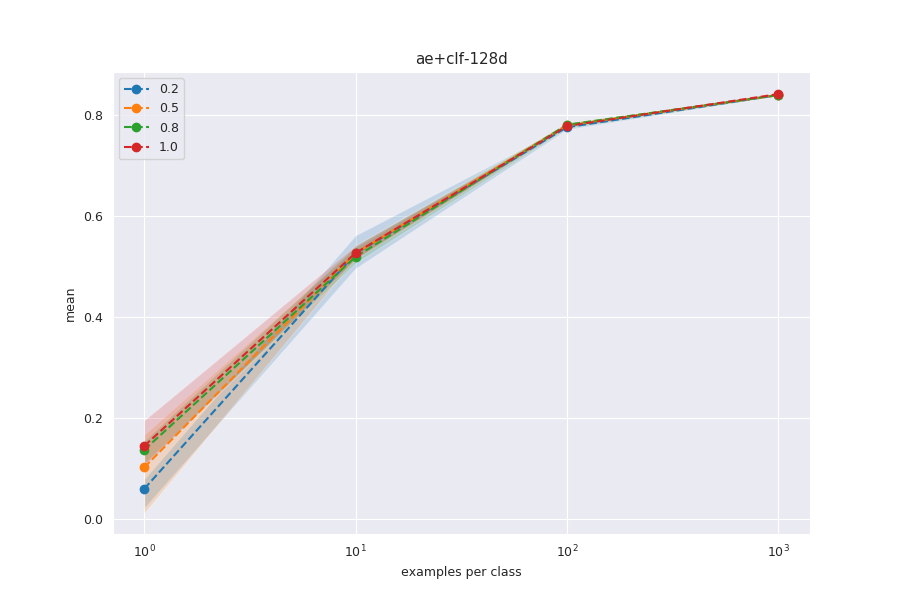

final_score                                          
                     count  mean   std   min   25%   50%   75%   max
epc      alpha                                                      
1.000    0.200       3.000 0.059 0.032 0.021 0.049 0.077 0.078 0.078
         0.500       3.000 0.101 0.080 0.011 0.069 0.127 0.146 0.166
         0.800       3.000 0.136 0.024 0.109 0.127 0.145 0.150 0.155
         1.000       3.000 0.144 0.046 0.104 0.118 0.133 0.164 0.195
10.000   0.200       3.000 0.525 0.033 0.496 0.507 0.518 0.540 0.561
         0.500       3.000 0.525 0.010 0.516 0.520 0.523 0.530 0.536
         0.800       3.000 0.518 0.019 0.506 0.507 0.508 0.524 0.540
         1.000       3.000 0.526 0.014 0.513 0.518 0.523 0.532 0.541
100.000  0.200       3.000 0.775 0.004 0.770 0.773 0.776 0.777 0.778
         0.500       3.000 0.779 0.005 0.774 0.777 0.780 0.782 0.784
         0.800       3.000 0.780 0.006 0.773 0.778 0.782 0.783 0.784
         1.000       3.000 0.777 0.002 0.776 0.776 0.776 0.778 0.779
1000.000 0.200       3.000 0.839 0.001 0.838 0.838 0.839 0.839 0.840
         0.500       3.000 0.838 0.001 0.838 0.838 0.839 0.839 0.839
         0.800       3.000 0.839 0.002 0.837 0.838 0.839 0.840 0.840
         1.000       3.000 0.840 0.002 0.839 0.839 0.840 0.841 0.843

In [5]:
plot_results('ae+clf-128d/results.txt')

---
 - encoding dim: 128
 - input dim: 20,752
 - tied weights
 - loss: sparse ce + bce (not contractive)
 - optimizer: Adam (lr = 1e-2)
 - run: 20190401

<IPython.core.display.Javascript object>


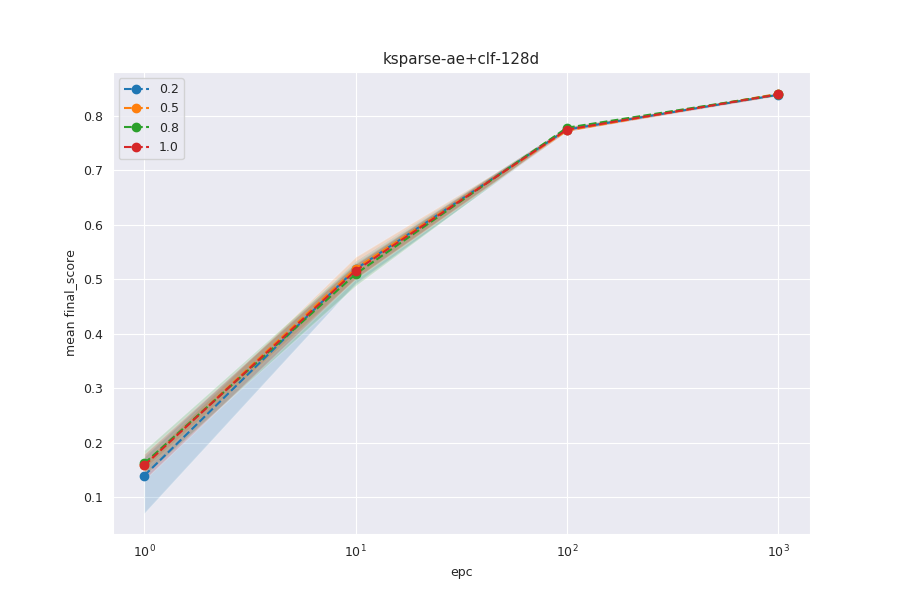

final_score                                          
                     count  mean   std   min   25%   50%   75%   max
epc      alpha                                                      
1.000    0.200       3.000 0.139 0.059 0.071 0.122 0.173 0.174 0.174
         0.500       3.000 0.158 0.007 0.152 0.155 0.158 0.161 0.165
         0.800       3.000 0.162 0.023 0.140 0.150 0.160 0.173 0.186
         1.000       3.000 0.158 0.024 0.132 0.148 0.163 0.171 0.179
10.000   0.200       3.000 0.518 0.023 0.492 0.511 0.529 0.531 0.533
         0.500       3.000 0.519 0.020 0.500 0.509 0.517 0.529 0.541
         0.800       3.000 0.509 0.021 0.488 0.499 0.509 0.520 0.530
         1.000       3.000 0.515 0.014 0.501 0.509 0.517 0.523 0.528
100.000  0.200       3.000 0.774 0.004 0.771 0.772 0.773 0.776 0.779
         0.500       3.000 0.773 0.002 0.771 0.772 0.773 0.773 0.774
         0.800       3.000 0.778 0.002 0.775 0.777 0.779 0.779 0.779
         1.000       3.000 0.774 0.005 0.771 0.771 0.772 0.776 0.780
1000.000 0.200       3.000 0.838 0.001 0.837 0.838 0.838 0.838 0.839
         0.500       3.000 0.840 0.001 0.839 0.839 0.839 0.840 0.841
         0.800       3.000 0.839 0.002 0.836 0.838 0.839 0.840 0.840
         1.000       3.000 0.839 0.003 0.836 0.837 0.839 0.840 0.841

In [16]:
plot_results('ksparse-ae+clf-128d/results.txt')

---
 - encoding dim: 128
 - input dim: 20,752
 - tied weights
 - loss: sparse ce + bce (not contractive)
 - optimizer: Adam (lr = 1e-2)
 - run: 20190402

<IPython.core.display.Javascript object>


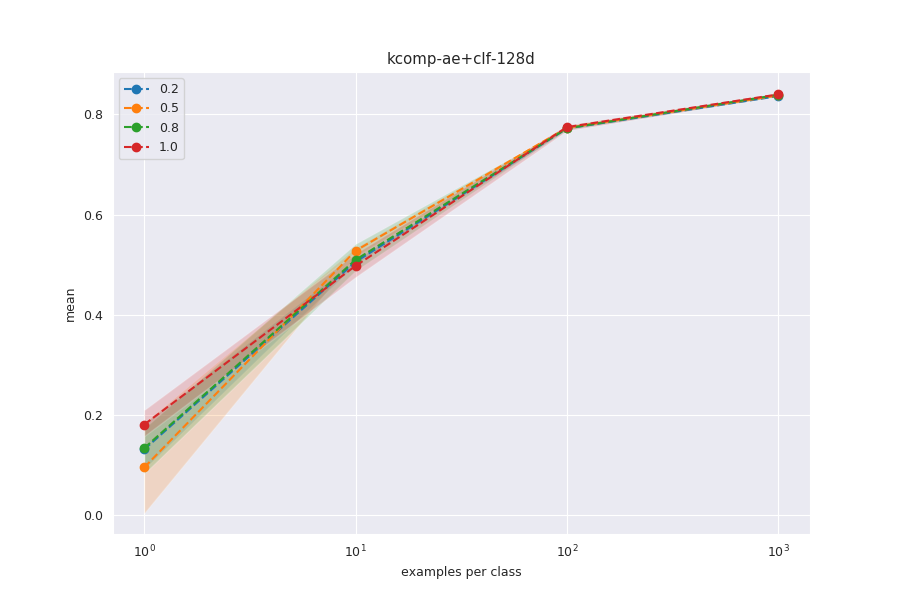

final_score                                          
                     count  mean   std   min   25%   50%   75%   max
epc      alpha                                                      
1.000    0.200       3.000 0.132 0.047 0.093 0.106 0.118 0.151 0.184
         0.500       3.000 0.096 0.090 0.005 0.051 0.098 0.141 0.185
         0.800       3.000 0.134 0.046 0.084 0.114 0.145 0.160 0.174
         1.000       3.000 0.181 0.026 0.158 0.167 0.175 0.193 0.210
10.000   0.200       3.000 0.506 0.004 0.502 0.504 0.506 0.508 0.510
         0.500       3.000 0.528 0.010 0.517 0.525 0.533 0.534 0.534
         0.800       3.000 0.510 0.028 0.488 0.494 0.499 0.521 0.542
         1.000       3.000 0.498 0.024 0.476 0.485 0.495 0.509 0.523
100.000  0.200       3.000 0.772 0.003 0.768 0.770 0.772 0.774 0.775
         0.500       3.000 0.773 0.003 0.770 0.771 0.773 0.775 0.777
         0.800       3.000 0.772 0.002 0.770 0.771 0.772 0.773 0.774
         1.000       3.000 0.775 0.006 0.768 0.772 0.777 0.778 0.779
1000.000 0.200       3.000 0.836 0.001 0.835 0.836 0.836 0.837 0.838
         0.500       3.000 0.838 0.002 0.836 0.837 0.838 0.839 0.839
         0.800       3.000 0.839 0.001 0.838 0.839 0.839 0.839 0.840
         1.000       3.000 0.840 0.003 0.836 0.838 0.841 0.842 0.843

In [14]:
plot_results('kcomp-ae+clf-128d/results.txt')

# Semi-supervised auto-encoder with contractive loss

 - encoding dim: 128
 - input dim: 14,376
 - tied weights
 - loss: sparse ce + bce + contractive loss (lambda = 1e-2)
 - optimizer: Adam (lr = 1e-3)
 - run: 20190401

<IPython.core.display.Javascript object>


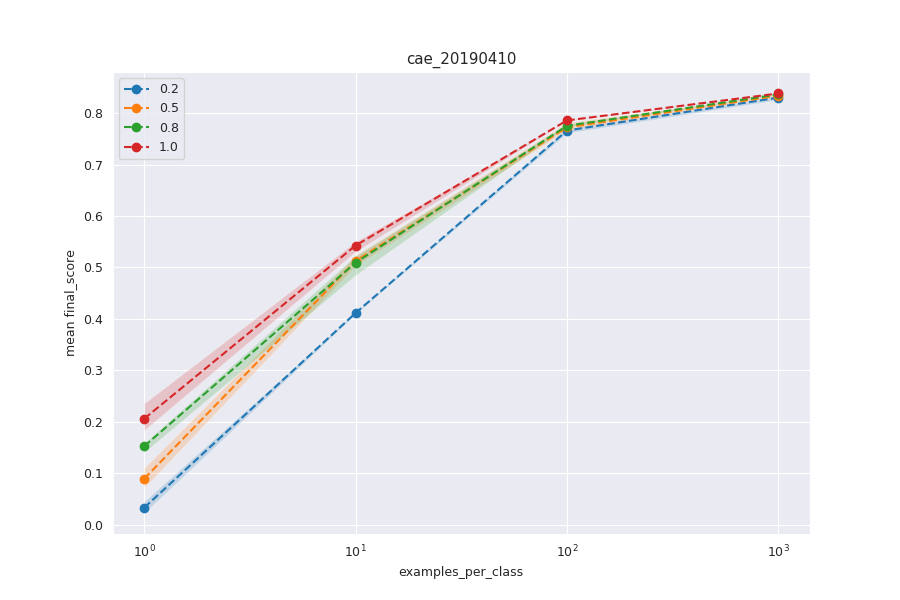

final_score                                          
                               count  mean   std   min   25%   50%   75%   max
examples_per_class alpha                                                      
1.000              0.200       3.000 0.033 0.012 0.023 0.027 0.031 0.038 0.046
                   0.500       3.000 0.089 0.020 0.072 0.079 0.085 0.098 0.111
                   0.800       3.000 0.153 0.010 0.140 0.149 0.158 0.159 0.159
                   1.000       3.000 0.206 0.027 0.184 0.191 0.198 0.217 0.236
10.000             0.200       3.000 0.411 0.002 0.409 0.411 0.412 0.413 0.413
                   0.500       3.000 0.513 0.011 0.503 0.507 0.511 0.517 0.524
                   0.800       3.000 0.509 0.021 0.485 0.502 0.520 0.521 0.523
                   1.000       3.000 0.543 0.010 0.531 0.539 0.546 0.548 0.551
100.000            0.200       3.000 0.766 0.004 0.761 0.764 0.767 0.768 0.770
                   0.500       3.000 0.772 0.008 0.767 0.767 0.768 0.775 0.782
                   0.800       3.000 0.775 0.003 0.773 0.774 0.774 0.776 0.779
                   1.000       2.000 0.786 0.001 0.785 0.785 0.786 0.786 0.787
1000.000           0.200       3.000 0.830 0.004 0.826 0.829 0.832 0.832 0.832
                   0.500       3.000 0.834 0.002 0.832 0.833 0.833 0.835 0.837
                   0.800       3.000 0.836 0.001 0.835 0.836 0.837 0.837 0.837
                   1.000       2.000 0.838 0.001 0.837 0.838 0.838 0.839 0.839

In [31]:
plot_results('cae_20190410/results.txt')

<IPython.core.display.Javascript object>


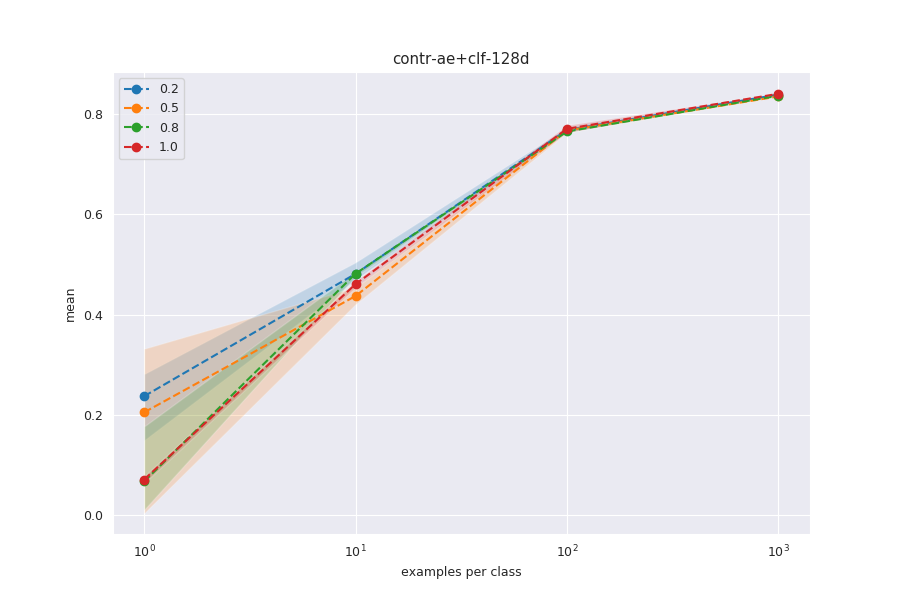

final_score                                          
                     count  mean   std   min   25%   50%   75%   max
epc      alpha                                                      
1.000    0.200       3.000 0.238 0.076 0.150 0.216 0.281 0.282 0.282
         0.500       3.000 0.206 0.176 0.005 0.142 0.279 0.306 0.332
         0.800       3.000 0.068 0.095 0.012 0.013 0.014 0.096 0.178
         1.000       3.000 0.072 0.007 0.065 0.069 0.072 0.075 0.078
10.000   0.200       3.000 0.482 0.020 0.470 0.470 0.470 0.488 0.505
         0.500       3.000 0.438 0.017 0.421 0.429 0.436 0.446 0.455
         0.800       3.000 0.482 0.005 0.477 0.480 0.484 0.485 0.486
         1.000       2.000 0.461 0.009 0.455 0.458 0.461 0.464 0.467
100.000  0.200       2.000 0.768 0.007 0.763 0.766 0.768 0.771 0.773
         0.500       2.000 0.768 0.006 0.764 0.766 0.768 0.770 0.772
         0.800       2.000 0.765 0.002 0.764 0.765 0.765 0.766 0.767
         1.000       2.000 0.771 0.010 0.764 0.767 0.771 0.774 0.778
1000.000 0.200       2.000 0.839 0.003 0.837 0.838 0.839 0.840 0.841
         0.500       2.000 0.835 0.001 0.835 0.835 0.835 0.836 0.836
         0.800       2.000 0.837 0.000 0.837 0.837 0.837 0.837 0.837
         1.000       2.000 0.841 0.002 0.839 0.840 0.841 0.841 0.842

In [4]:
plot_results('contr-ae+clf-128d/results.txt')

<IPython.core.display.Javascript object>


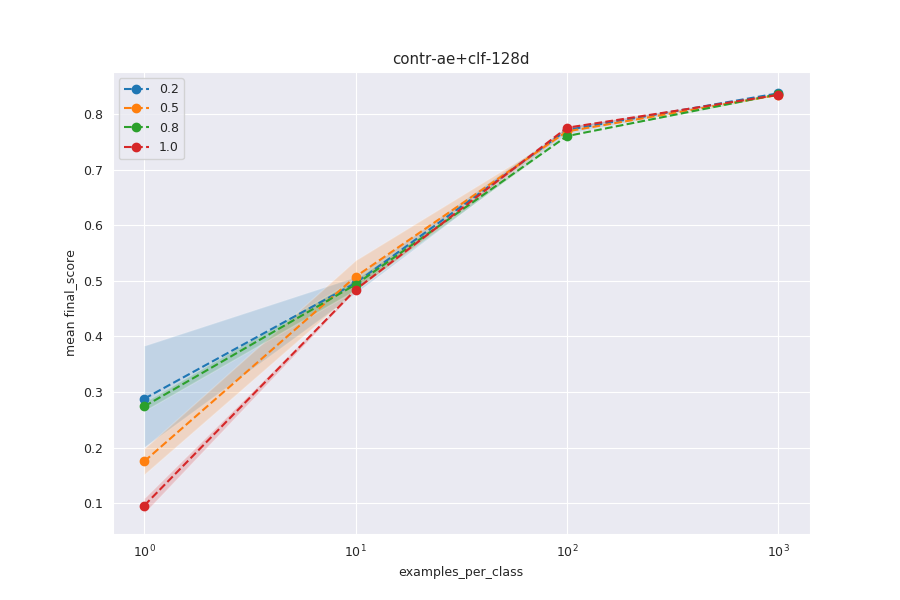

final_score                                          
                               count  mean   std   min   25%   50%   75%   max
examples_per_class alpha                                                      
1.000              0.200       3.000 0.288 0.091 0.201 0.240 0.279 0.331 0.384
                   0.500       3.000 0.175 0.023 0.152 0.164 0.175 0.187 0.199
                   0.800       2.000 0.274 0.011 0.266 0.270 0.274 0.278 0.282
                   1.000       2.000 0.096 0.019 0.083 0.089 0.096 0.102 0.109
10.000             0.200       3.000 0.496 0.016 0.478 0.491 0.503 0.505 0.507
                   0.500       3.000 0.507 0.027 0.483 0.493 0.502 0.520 0.537
                   0.800       2.000 0.493 0.014 0.483 0.488 0.493 0.498 0.503
                   1.000       2.000 0.484 0.002 0.483 0.483 0.484 0.485 0.485
100.000            0.200       3.000 0.771 0.006 0.765 0.768 0.772 0.774 0.777
                   0.500       2.000 0.769 0.001 0.768 0.768 0.769 0.769 0.770
                   0.800       2.000 0.760 0.000 0.760 0.760 0.760 0.760 0.760
                   1.000       2.000 0.775 0.004 0.773 0.774 0.775 0.777 0.778
1000.000           0.200       3.000 0.837 0.000 0.837 0.837 0.837 0.837 0.838
                   0.500       2.000 0.834 0.002 0.833 0.834 0.834 0.835 0.836
                   0.800       2.000 0.835 0.003 0.834 0.835 0.835 0.836 0.837
                   1.000       2.000 0.834 0.001 0.834 0.834 0.834 0.835 0.835

In [154]:
plot_results('contr-ae+clf-128d/results.txt')

<IPython.core.display.Javascript object>


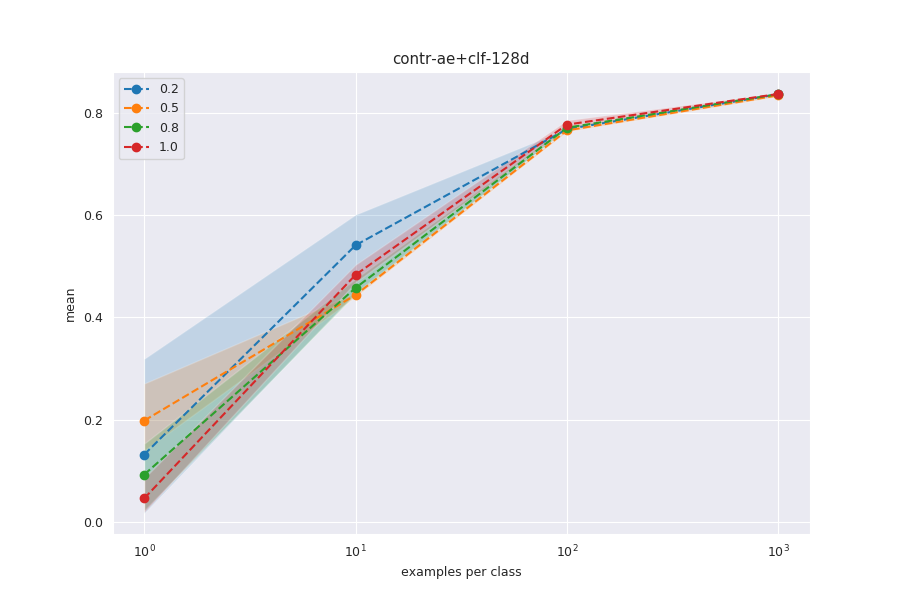

final_score                                          
                     count  mean   std   min   25%   50%   75%   max
epc      alpha                                                      
1.000    0.200       3.000 0.132 0.163 0.017 0.038 0.059 0.189 0.319
         0.500       3.000 0.198 0.067 0.139 0.162 0.184 0.227 0.270
         0.800       3.000 0.092 0.066 0.023 0.062 0.101 0.127 0.153
         1.000       3.000 0.046 0.035 0.019 0.026 0.033 0.059 0.085
10.000   0.200       3.000 0.541 0.081 0.448 0.511 0.573 0.587 0.601
         0.500       3.000 0.444 0.004 0.440 0.442 0.443 0.445 0.448
         0.800       3.000 0.457 0.016 0.445 0.448 0.452 0.463 0.475
         1.000       3.000 0.483 0.018 0.468 0.473 0.478 0.490 0.503
100.000  0.200       3.000 0.768 0.001 0.767 0.767 0.768 0.768 0.769
         0.500       3.000 0.765 0.002 0.763 0.764 0.766 0.767 0.767
         0.800       3.000 0.771 0.002 0.769 0.769 0.770 0.772 0.773
         1.000       3.000 0.777 0.008 0.770 0.772 0.775 0.780 0.785
1000.000 0.200       3.000 0.836 0.002 0.834 0.835 0.837 0.837 0.837
         0.500       3.000 0.834 0.002 0.832 0.833 0.834 0.835 0.836
         0.800       3.000 0.836 0.001 0.835 0.836 0.836 0.836 0.837
         1.000       3.000 0.837 0.002 0.835 0.836 0.836 0.837 0.838

In [18]:
plot_results('contr-ae+clf-128d/results.txt')

# Semi-supervised Competitive Auto-encoder

# Semi-supervised Sparse Auto-encoder with contractive loss 


 - encoding dim: 128 (k=32)
 - input dim: 20,752
 - tied weights
 - loss: sparse ce + bce + contractive loss (lambda=1e-2)
 - optimizer: Adam (lr = 1e-2)
 - run: 20190401

<IPython.core.display.Javascript object>


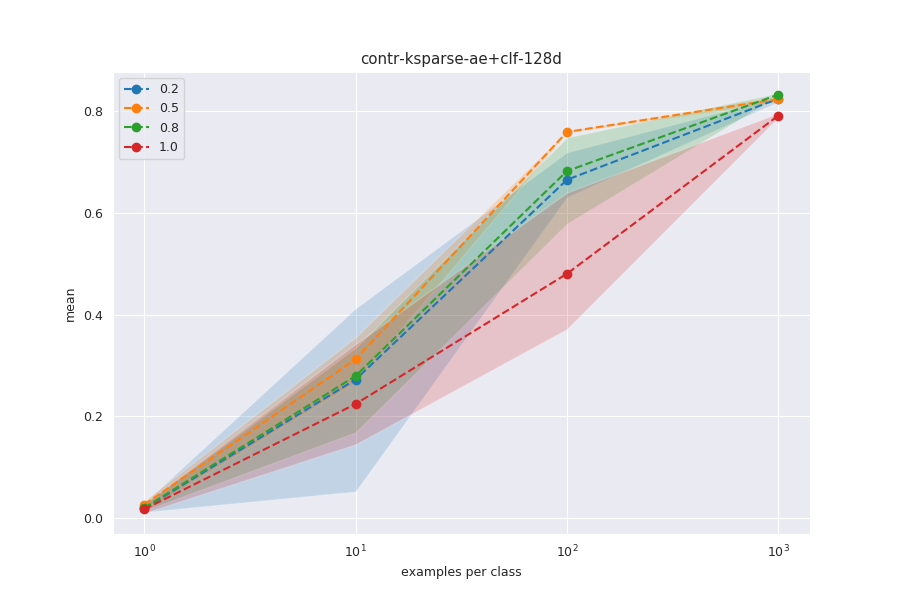

final_score                                          
                     count  mean   std   min   25%   50%   75%   max
epc      alpha                                                      
1.000    0.200       3.000 0.019 0.010 0.012 0.013 0.014 0.022 0.030
         0.500       3.000 0.026 0.011 0.013 0.022 0.032 0.033 0.034
         0.800       3.000 0.020 0.007 0.014 0.016 0.018 0.022 0.027
         1.000       3.000 0.017 0.010 0.010 0.011 0.013 0.021 0.028
10.000   0.200       3.000 0.272 0.193 0.052 0.202 0.352 0.382 0.412
         0.500       3.000 0.312 0.044 0.267 0.290 0.314 0.334 0.355
         0.800       3.000 0.279 0.096 0.168 0.251 0.334 0.334 0.335
         1.000       3.000 0.224 0.104 0.145 0.165 0.185 0.264 0.342
100.000  0.200       3.000 0.665 0.047 0.631 0.638 0.645 0.682 0.719
         0.500       3.000 0.759 0.002 0.757 0.758 0.759 0.760 0.761
         0.800       3.000 0.682 0.091 0.579 0.649 0.719 0.734 0.748
         1.000       3.000 0.480 0.141 0.372 0.400 0.429 0.534 0.640
1000.000 0.200       3.000 0.824 0.005 0.818 0.823 0.827 0.827 0.828
         0.500       3.000 0.824 0.006 0.817 0.821 0.824 0.827 0.829
         0.800       3.000 0.833 0.003 0.830 0.831 0.832 0.834 0.836
         1.000       3.000 0.791 0.004 0.788 0.789 0.790 0.793 0.796

In [15]:
plot_results('contr-ksparse-ae+clf-128d/results.txt')

# Supervised Classifiers

 - sequence length: 2000
 - model architectures:
  - CNN
  - parallel CNN
  - LSTM
  - Bidirectional LSTM
 - optimizer: Adam
 - run: 20190208

<IPython.core.display.Javascript object>


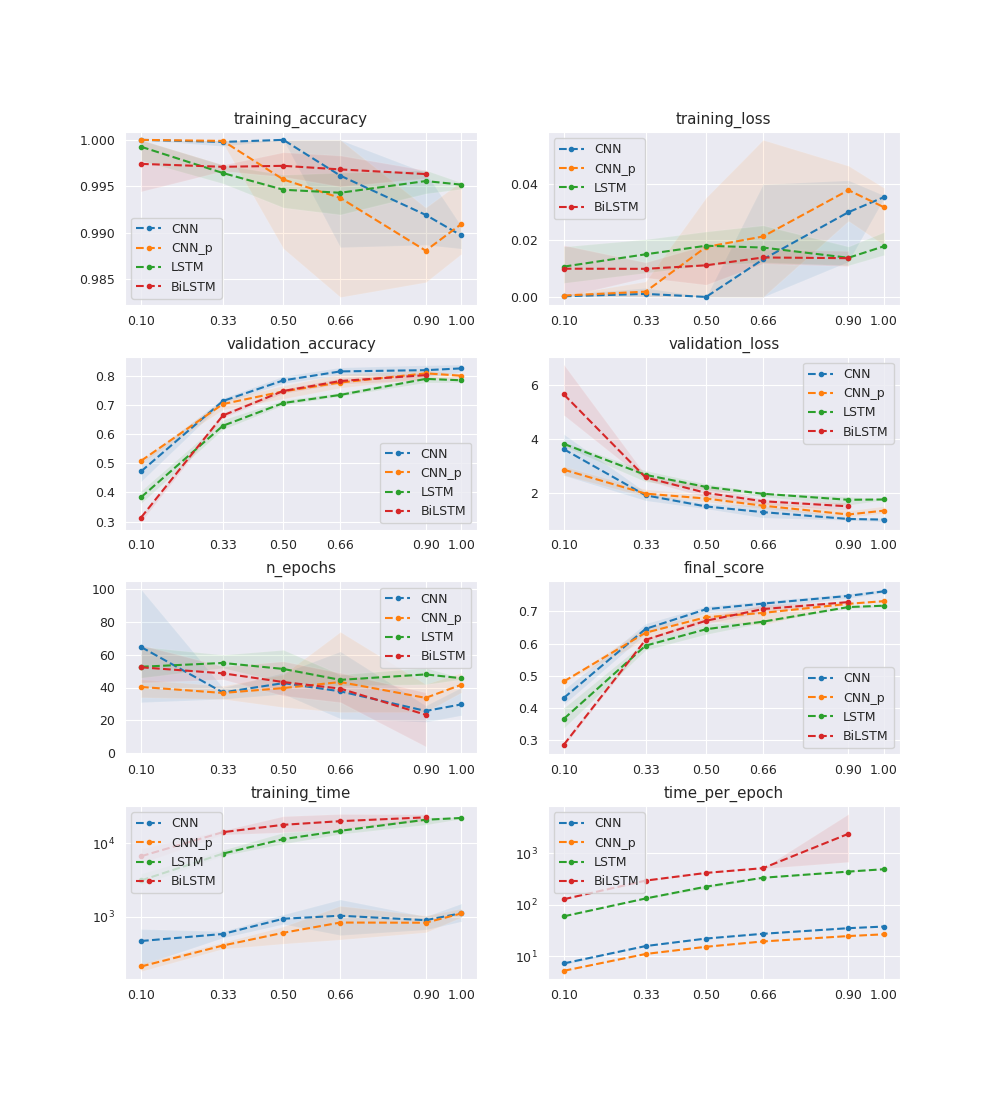

In [9]:
model_names = ["CNN", "CNN_p", "LSTM", "BiLSTM"]

metrics = [
    'training_accuracy', 'training_loss', 
    'validation_accuracy', 'validation_loss', 
    'n_epochs', 'final_score', 
    'training_time', 'time_per_epoch']

supervised_rates = np.array([.1, .33, .5, .66, .9, 1.])
log_scales = ['training_time', 'time_per_epoch']

def load_scores(filename):
    scores = pd.read_csv('../outputs/' + filename, sep=';')
    scores.columns = list(map(lambda s: s.strip(), scores.columns))
    return scores.assign(
        id=sorted([1] + [i for a in [np.arange(1, 25)] * 3 for i in a])[:len(scores)], 
        model_id=sorted([1] + [i for a in [np.arange(1, 5)] * 18 for i in a])[:len(scores)], 
        time_per_epoch=scores['training_time'] / scores['n_epochs'])
    
def plot_scores(scores):
    avg_scores = scores[['id', 'model_id', *metrics]].groupby('id').agg(['mean', 'min', 'max'])
    avg_scores['supervised_rate'] = [r for a in [supervised_rates] * 4 for r in a][:len(avg_scores)]
    n_models = avg_scores[('model_id', 'mean')].max()

    fig, axs = plt.subplots(4, 2, figsize=(10, 11))
    for ax, metric in zip([ax for ar in axs for ax in ar], metrics):
        for i in range(1, n_models + 1):
            y = avg_scores.loc[avg_scores[('model_id', 'mean')] == i, metric]
            y, ymin, ymax = y['mean'], y['min'], y['max']
            ax.plot(supervised_rates[:len(y)], y, '.--')
            ax.fill_between(supervised_rates[:len(y)], ymin, ymax, alpha=0.1)
        if metric in log_scales:
            ax.set_yscale('log')
        ax.set_title(metric)
        ax.legend(model_names[:n_models])
        ax.set_xticks(supervised_rates)
        
    plt.subplots_adjust(hspace=0.3)
    plt.savefig("tmp/baseline.png")
    
scores = load_scores('baseline.csv')
# display(scores)

plot_scores(scores)